## Econ 409/442 Homework 3 - Arturs Apinis

In [51]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
from fredapi import Fred
import statsmodels.formula.api as smf
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [52]:
# load in forward PE data on utilities
sectors = pd.read_excel("forwardsector.xlsx", index_col = 0, parse_dates = True)[["S5UTIL Index  (R1)"]][::-1]
sectors.columns = ["Sector PE"]

In [53]:
# pull in prices for the utilities etf
sector = "XLU"
sector = yf.download(sector)[["Adj Close"]].copy()

[*********************100%***********************]  1 of 1 completed


In [54]:
# merge fundamentals
data = pd.merge_asof(sectors, sector,left_index = True, right_index = True)
data["returns"] = np.log(data["Adj Close"]).diff()
data.dropna(inplace = True)

In [55]:
time_diffs = data.index.to_series().diff()
threshold = pd.Timedelta(days=32)
if (time_diffs > threshold).any():
    print("Data has jumps or discontinuities.")
else:
    print("Data does not have jumps or discontinuities.")
    
mask = time_diffs > threshold

jumps = data[mask]

jumps

Data has jumps or discontinuities.


,Sector PE,Adj Close,returns
Date,,,
2005-07-29,15.8089,17.419216,0.020038


In [56]:
# there is a gap in the data before this time, so I snip off that period
data = data[data.index.year >= 2005].copy()

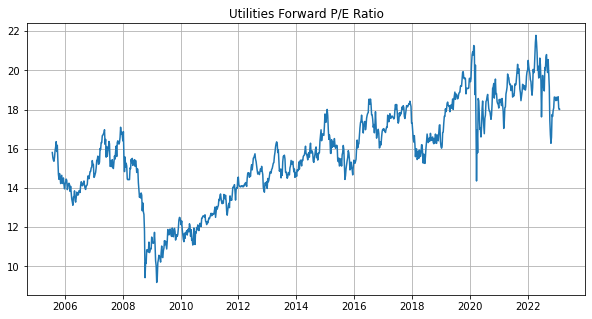

In [57]:
plt.figure(figsize = (10, 5))
plt.plot(data["Sector PE"])
plt.title("Utilities Forward P/E Ratio")

plt.grid()

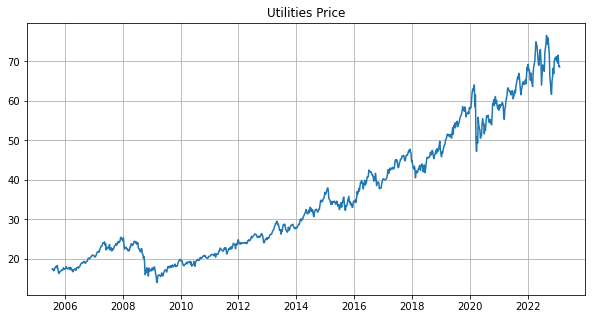

In [58]:
plt.figure(figsize = (10, 5))
plt.plot(data["Adj Close"])
plt.title("Utilities Price")

plt.grid()

## Please specify below the candidate k and h values that you want to test

In [59]:
cut = int((len(data) * .8) //1)

In [60]:
in_data = data[:cut]
out_data = data[cut:]

In [61]:
# specify candidate values for hyperparameters
ks = np.linspace(.01, .99, 10)
zs = np.linspace(.01, 3, 10)
ws = np.arange(5, 30, 5)
hs =  np.arange(1)

import itertools as it
# build a grid with all possible hyperparameters
grid = np.array(np.meshgrid(ks,zs, ws, hs)).T.reshape(-1,4)

grid

array([[1.00000000e-02, 1.00000000e-02, 5.00000000e+00, 0.00000000e+00],
       [1.00000000e-02, 3.42222222e-01, 5.00000000e+00, 0.00000000e+00],
       [1.00000000e-02, 6.74444444e-01, 5.00000000e+00, 0.00000000e+00],
       ...,
       [9.90000000e-01, 2.33555556e+00, 2.50000000e+01, 0.00000000e+00],
       [9.90000000e-01, 2.66777778e+00, 2.50000000e+01, 0.00000000e+00],
       [9.90000000e-01, 3.00000000e+00, 2.50000000e+01, 0.00000000e+00]])

# This block iterates through all the combinations and calculates the returns for each

In [62]:
storage = pd.DataFrame(columns = ["k", "z", "w", "h", "profits"])
df_copy = in_data.copy()

for n in range(len(grid)):
    # Each loop we pull out the values for a new set of hyperparamters from the grid
    k,z,w,h= grid[n]
    
    # We fit a filter and CI using the next set of parameters
    df_copy["Filter"] = df_copy["Sector PE"].ewm(alpha = k, adjust = False).mean()
    df_copy["Filter Error"] = df_copy["Sector PE"] -df_copy["Filter"]
    df_copy["std"] = df_copy["Filter Error"].rolling(int(w)).std()
    df_copy["Upper"] = df_copy["Filter"] + z*df_copy["std"]
    df_copy["Lower"] = df_copy["Filter"] - z*df_copy["std"]
    df_copy["test"] = np.where(df_copy["Filter Error"].abs()>z*df_copy["std"], 1, 0)*np.sign(df_copy["Filter Error"])
    
    # create vectors where we can store information on signals and when the change is first signalled
    df_copy["test2"] = 0
    df_copy["signal"] = 0
    
    for j in df_copy.index:
        # if there is a change in the signal, we want to take a position for teh next h periods
        if (df_copy.loc[j, "test"] == 1) &  (df_copy.shift().loc[j, "test"] != 1):
            df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
            df_copy.loc[j, "test2"] = 1
        elif (df_copy.loc[j, "test"] == -1) &  (df_copy.shift().loc[j, "test"] != -1):
            df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
            df_copy.loc[j, "test2"] = -1
    
    # calculate metric
    df_copy["cumulative_returns"] = np.exp((df_copy["signal"].shift()*df_copy.returns).cumsum())-1
    
    # store the results
    storage = storage.append({"k":k, "z":z, "w":w, "h":h,
                "profits":df_copy["cumulative_returns"][-1]}, ignore_index = True)
    # print so I can track progress of loop (can take a few minutes)
    #print(n)

In [63]:
storage = storage.sort_values(by = "profits").reset_index(drop = True)

Text(0.5, 1.0, 'z optimization')

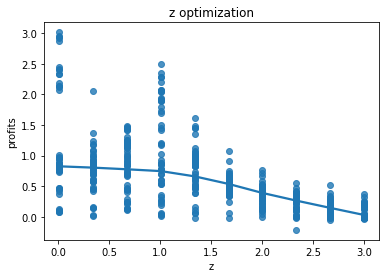

In [64]:
import seaborn as sns
sns.regplot(data = storage, x = "z", y = "profits", lowess = True)
plt.title("z optimization")

# This will build a heatmap

In [65]:
def heatmap(x, y, metric, values):
    
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).max(),1)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)

    # make plot
    f, ax = plt.subplots(figsize=(25, 12))
    ax = sns.heatmap(heat, fmt='.1g')
    ax.set_title("Heat map of "+ metric,size = 18)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale=1)
    plt.show()

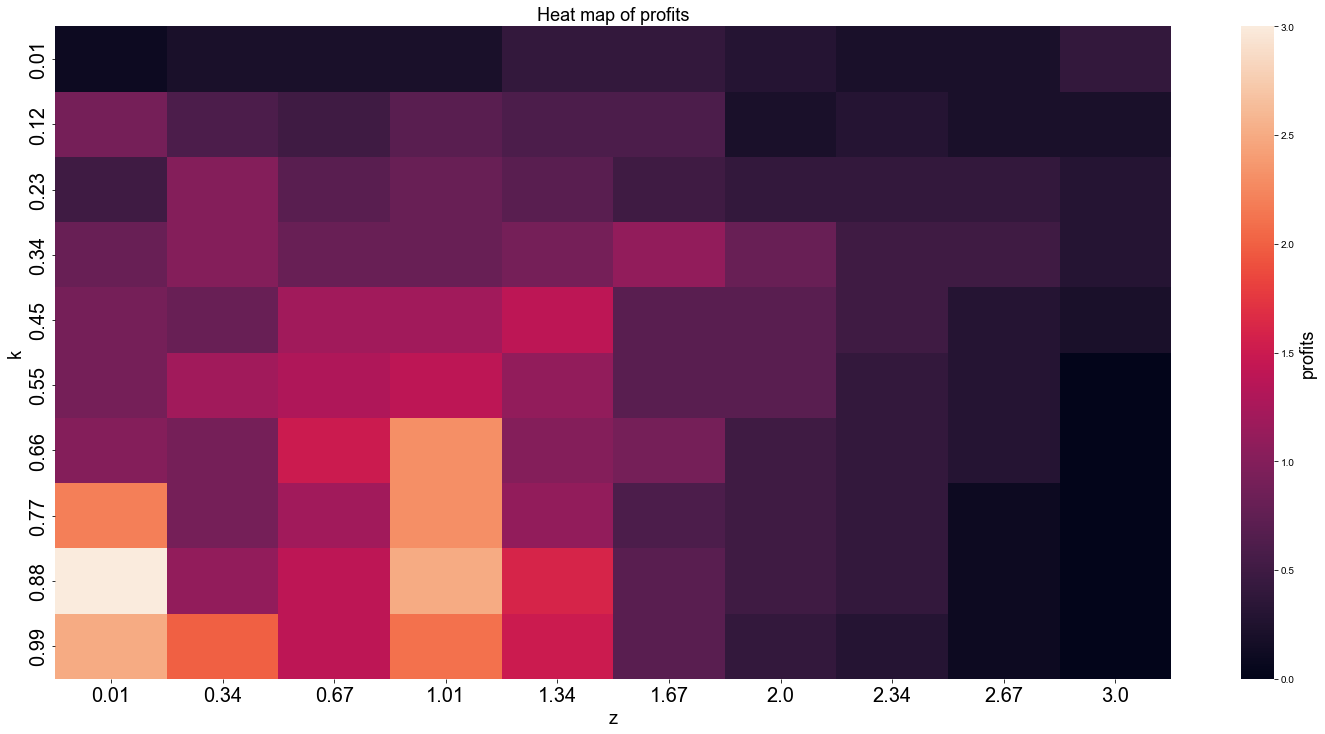

In [66]:
heatmap("k", "z","profits", storage)

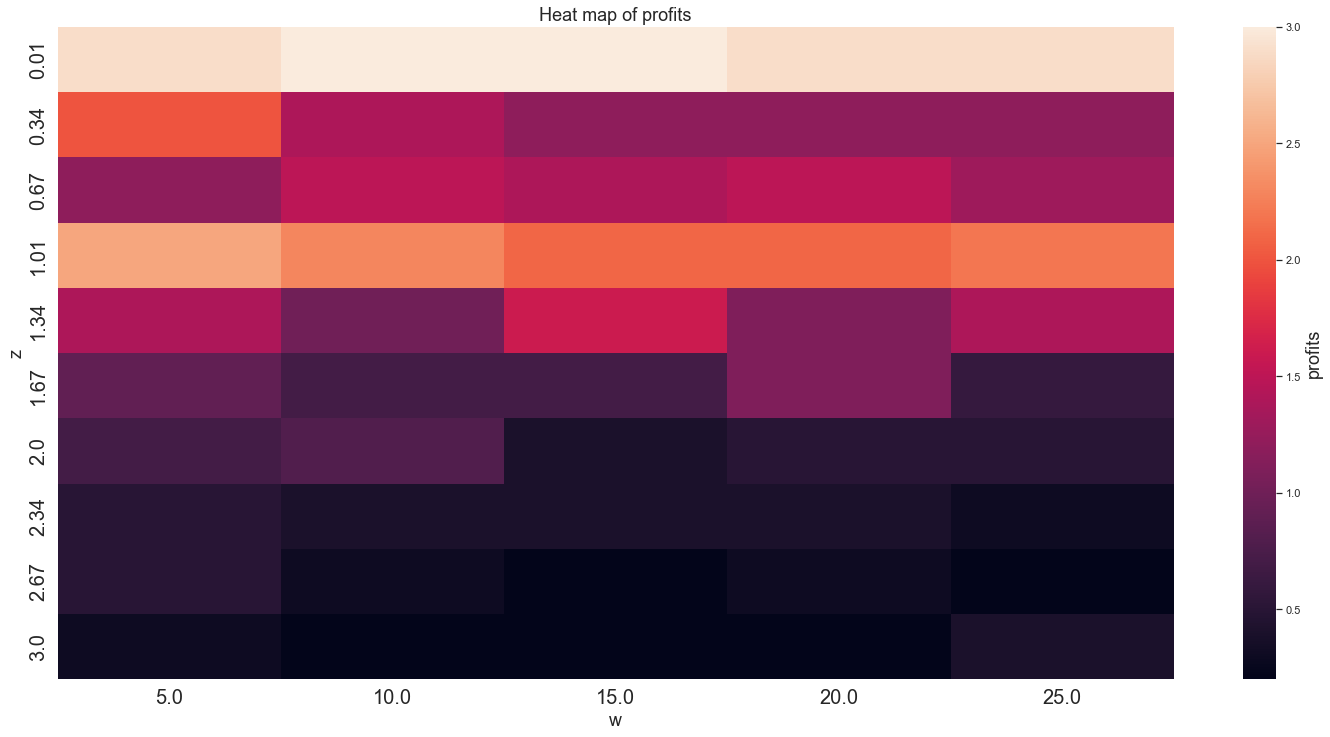

In [67]:
heatmap("z", "w","profits", storage)

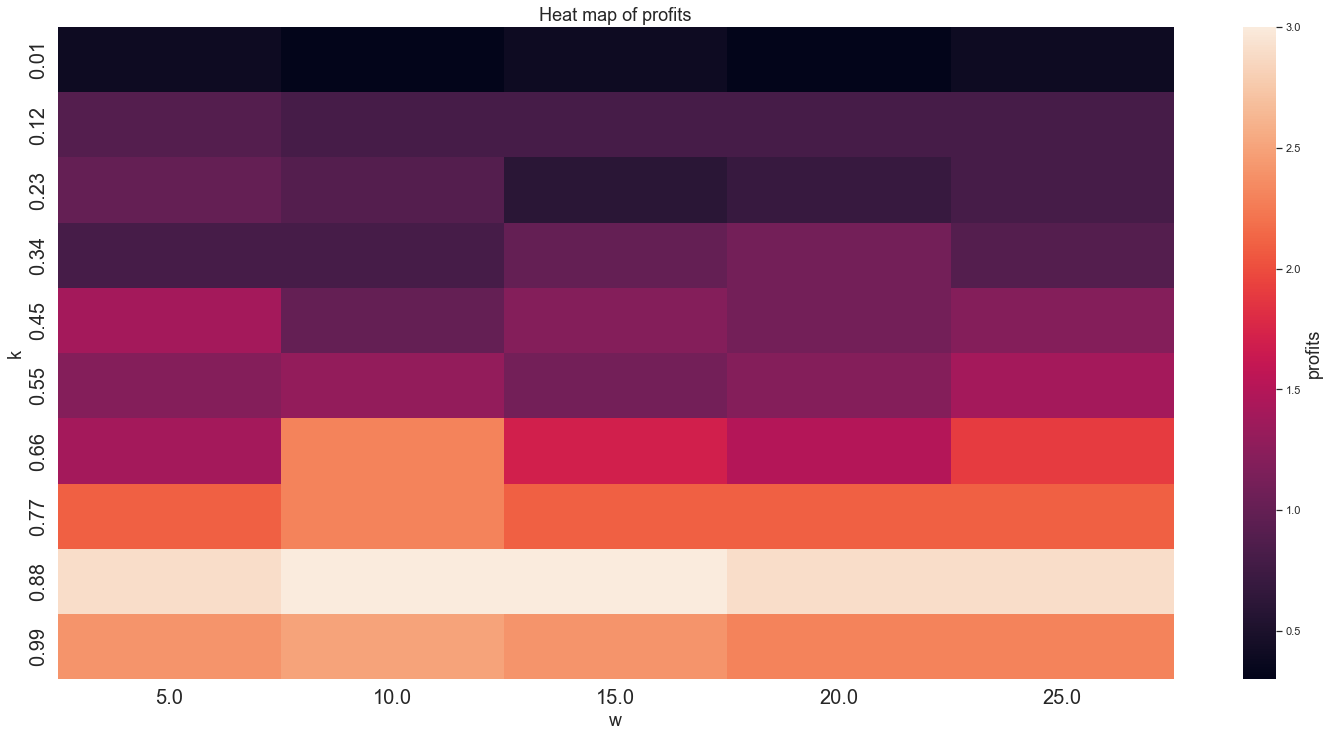

In [68]:
heatmap("k", "w","profits", storage)

In [69]:
storage.iloc[490:]

,k,z,w,h,profits
490,0.663333,1.006667,10.0,0.0,2.349753
491,0.99,0.01,15.0,0.0,2.400313
492,0.99,0.01,5.0,0.0,2.409003
493,0.99,0.01,10.0,0.0,2.453383
494,0.881111,1.006667,5.0,0.0,2.491722
495,0.881111,0.01,25.0,0.0,2.874409
496,0.881111,0.01,20.0,0.0,2.924566
497,0.881111,0.01,5.0,0.0,2.938759
498,0.881111,0.01,15.0,0.0,2.961037
499,0.881111,0.01,10.0,0.0,3.014244


In [70]:
k,z,w, h, p = storage.iloc[-1]

In [71]:
storage.iloc[-1]

k          0.881111
z              0.01
w              10.0
h               0.0
profits    3.014244
Name: 499, dtype: object

In [72]:
df_copy = out_data

In [73]:
df_copy["Filter"] = df_copy["Sector PE"].ewm(alpha = k, adjust = False).mean()
df_copy["Filter Error"] = df_copy["Sector PE"] -df_copy["Filter"]
df_copy["std"] = df_copy["Filter Error"].rolling(int(w)).std()
df_copy["Upper"] = df_copy["Filter"] + z*df_copy["std"]
df_copy["Lower"] = df_copy["Filter"] - z*df_copy["std"]

df_copy["test"] = np.where(df_copy["Filter Error"].abs()>z*df_copy["std"], 1, 0)*np.sign(df_copy["Filter Error"])

df_copy["test2"] = 0
df_copy["signal"] = 0
for j in df_copy.index:
    if (df_copy.loc[j, "test"] == 1) &  (df_copy.shift().loc[j, "test"] != 1):
        df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
        df_copy.loc[j, "test2"] = 1
    elif (df_copy.loc[j, "test"] == -1) &  (df_copy.shift().loc[j, "test"] != -1):
        df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
        df_copy.loc[j, "test2"] = -1
df_copy["cumulative_returns"] = (np.exp((df_copy["signal"].shift()*df_copy.returns).cumsum())-1)
df_copy["strat_returns"] = df_copy["signal"].shift()*df_copy.returns

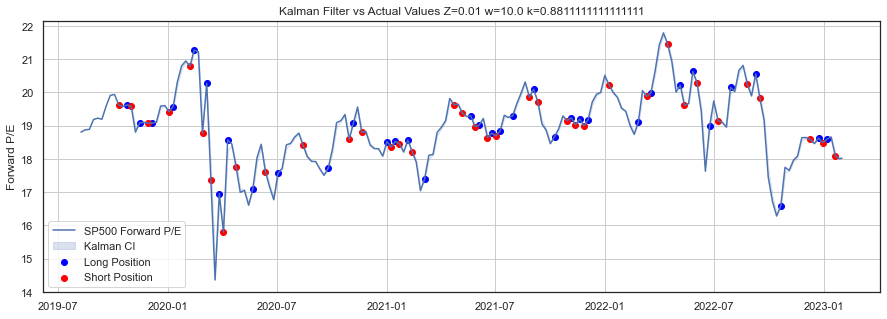

In [74]:
sns.set_style("white")
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Forward P/E")
ax.plot(df_copy["Sector PE"])
#ax.plot(df_copy["Filter"])


ax.fill_between(df_copy.index, df_copy.Lower, df_copy.Upper, color='b', alpha=.2)
ax.scatter(df_copy[df_copy.test2 == 1].index, df_copy[df_copy.test2 == 1]["Sector PE"], color = "blue")
ax.scatter(df_copy[df_copy.test2 == -1].index, df_copy[df_copy.test2 == -1]["Sector PE"], color = "red")

#ax.axvline(df_copy.index[-5], color = "red", linestyle = '--')
ax.legend(["SP500 Forward P/E", "Kalman CI", "Long Position", "Short Position"])


#plt.xlim([datetime.date(2000, 1, 1), datetime.date(2004, 1, 1)])
ax.grid()

# Below we can pick out a specific combination and see how it performs. For this example I use the best performing one. 

In [75]:
df_copy["success"] = ((df_copy[df_copy.test2 != 0]["cumulative_returns"].diff()>0)*1).shift(-1)

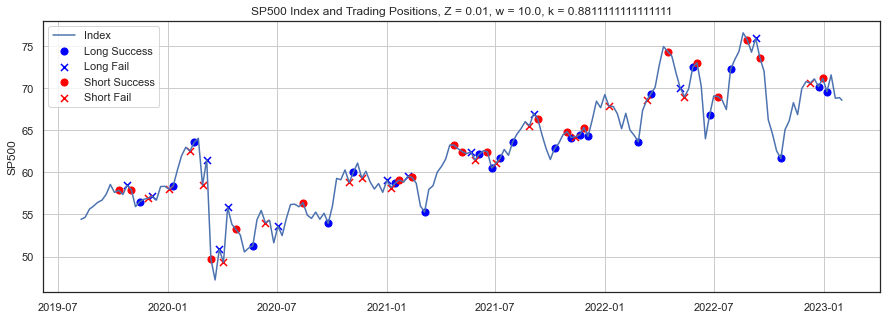

In [76]:
plt.figure(figsize = (15, 5))

plt.title("SP500 Index and Trading Positions"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))
plt.ylabel("SP500")
plt.plot(df_copy["Adj Close"])

longsuccess = df_copy[(df_copy["success"] == 1) & (df_copy["test2"] == 1)]
longfail = df_copy[(df_copy["success"] == 0) & (df_copy["test2"] == 1)] 
shortsuccess = df_copy[(df_copy["success"] == 1) & (df_copy["test2"] == -1)]
shortfail = df_copy[(df_copy["success"] == 0) & (df_copy["test2"] == -1)]

plt.scatter(longsuccess.index, longsuccess["Adj Close"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["Adj Close"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["Adj Close"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["Adj Close"], color = 'red', s = 50, marker = "x")

plt.legend(["Index", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

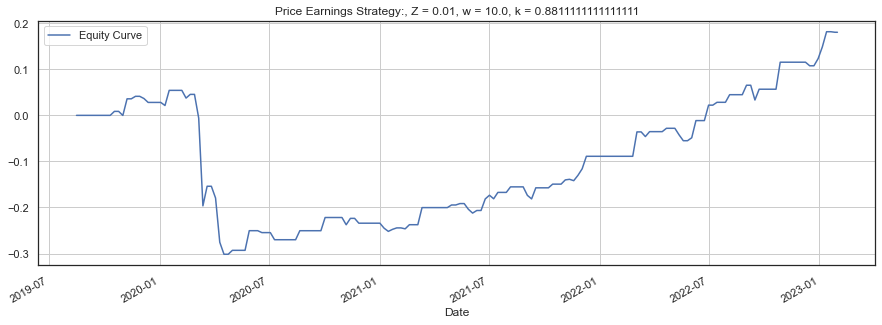

In [77]:
plt.figure(figsize = (15, 5))
(df_copy["cumulative_returns"]).plot()

plt.title("Price Earnings Strategy:"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))

plt.legend(["Equity Curve"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

In [80]:
df_copy

,Sector PE,Adj Close,returns,Filter,Filter Error,std,Upper,Lower,test,test2,signal,cumulative_returns,strat_returns,success
Date,,,,,,,,,,,,,,
2019-08-09,18.8029,54.422264,0.010582,18.802900,0.000000,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN
2019-08-16,18.8718,54.663948,0.004431,18.863609,0.008191,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN
2019-08-23,18.8839,55.621696,0.017369,18.881488,0.002412,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN
2019-08-30,19.1832,55.997643,0.006736,19.147330,0.035870,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN
2019-09-06,19.2218,56.445194,0.007961,19.212946,0.008854,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-06,18.5873,69.599998,-0.022447,18.577006,0.010294,0.025076,18.577257,18.576755,1.0,1,1,0.148746,0.022447,1.0
2023-01-13,18.6572,71.589996,0.028191,18.647666,0.009534,0.024973,18.647916,18.647416,1.0,0,0,0.181591,0.028191,NaN
2023-01-20,18.0841,68.820000,-0.039461,18.151102,-0.067002,0.034133,18.151443,18.150760,-1.0,-1,-1,0.181591,-0.000000,NaN


In [83]:
# Total rate of return: 

Total_Return = float(df_copy.cumulative_returns.iloc[-1:])*100
print('The total rate of return is: ' + str(Total_Return) + '%')

The total rate of return is: 18.039038596502333%


In [84]:
# Annualised return:

P = 1000
A = (((df_copy["cumulative_returns"])+1)*P)[-1]
t = (len(df_copy)/52)
CCROR = np.log(A/P)/t
#print(CCROR*100)


((A/P)**(1/t)-1)*100
print('The annualised rate of return is: ' + str(((A/P)**(1/t)-1)*100) + '%')

The annualised rate of return is: 4.825347017970083%


In [88]:
# Only when holding 

df_copy_only = df_copy.loc[df_copy["signal"] != 0, "cumulative_returns"]
df_copy_only = pd.DataFrame(data=df_copy_only)
df_copy_only

,cumulative_returns
Date,
2019-10-11,0.000000
2019-10-25,0.008646
2019-11-01,-0.000223
2019-11-15,0.035892
2019-11-29,0.041348
...,...
2022-12-09,0.115403
2022-12-23,0.107625
2022-12-30,0.123247


In [90]:
Holding_Total_Return = float(df_copy_only.cumulative_returns.iloc[-1:])*100
print('The holding total rate of return is: ' + str(Holding_Total_Return) + '%')

The holding total rate of return is: 18.159101030616576%


In [87]:
P = 1000
A = (((df_copy_only["cumulative_returns"])+1)*P)[-1]
t = (len(df_copy_only)/52)
CCROR = np.log(A/P)/t
#print(CCROR*100)

((A/P)**(1/t)-1)*100
print('The annualised rate of return is: ' + str(((A/P)**(1/t)-1)*100) + '%')

11.88604917143917
The annualised rate of return is: 12.62127913126041%


In [309]:
# Sharpe

rf_rate = pd.read_csv('1-year-treasury-rate-yield-chart.csv', index_col=0, parse_dates=True).dropna()

In [373]:
df_copy['rfr'] = rf_rate
df_copy = df_copy.ffill()
df_copy['returns_in_pct'] = df_copy['returns']*100
df_copy['rfr_52'] = df_copy['rfr']/52
df_copy

,Sector PE,Adj Close,returns,Filter,Filter Error,std,Upper,Lower,test,test2,signal,cumulative_returns,strat_returns,success,rfr,returns_in_pct,rfr_52
Date,,,,,,,,,,,,,,,,,
2019-08-09,18.8029,54.422268,0.010582,18.802900,0.000000,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN,0.001471,1.058215,0.000028
2019-08-16,18.8718,54.663944,0.004431,18.863609,0.008191,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN,0.001414,0.443093,0.000027
2019-08-23,18.8839,55.621708,0.017369,18.881488,0.002412,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN,0.001430,1.736922,0.000028
2019-08-30,19.1832,55.997646,0.006736,19.147330,0.035870,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN,0.001455,0.673610,0.000028
2019-09-06,19.2218,56.445198,0.007961,19.212946,0.008854,NaN,NaN,NaN,0.0,0,0,0.000000,0.000000,NaN,0.001430,0.796056,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-06,18.5873,69.599998,-0.022447,18.577006,0.010294,0.025076,18.577257,18.576755,1.0,1,1,0.148746,0.022447,1.0,0.003763,-2.244734,0.000072
2023-01-13,18.6572,71.589996,0.028191,18.647666,0.009534,0.024973,18.647916,18.647416,1.0,0,0,0.181590,0.028191,1.0,0.003763,2.819080,0.000072
2023-01-20,18.0841,68.820000,-0.039461,18.151102,-0.067002,0.034133,18.151443,18.150760,-1.0,-1,-1,0.181590,-0.000000,1.0,0.003763,-3.946095,0.000072


In [311]:
def sharpe_ratio(returns, rfr):
    excess_returns = returns - rfr
    n = len(excess_returns)
    mean = excess_returns.mean()
    std = np.sqrt(np.sum(np.square(excess_returns))/(n-1))
    return(mean/std)

In [312]:
returns = df_copy["returns_in_pct"]
rfr = df_copy['rfr_52']
sharpe_ratio(returns, rfr)

0.03402480619120572

In [49]:
# Gini

def GINI_COEF(returns):
    # get the number of periods -> will allow us to calculate the areas
    periods = len(returns)
    
    # sort values and sum to calculate the lorenz curve
    LorenzCurve = np.cumsum(returns.sort_values( by = "Returns"))
    # start from 0
    LorenzCurve = pd.DataFrame({ 'Returns': [0]}).append(LorenzCurve)
    Line = LorenzCurve.copy()
    # Form the line that encompasses A and B
    Line["Returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["Returns"])
    
    # calculate the area of A+B
    UpArea = 0
    for i in range(1,len(returns)):
        UpArea = UpArea + ((Line.iloc[i,:] - LorenzCurve.iloc[i,:] + Line.iloc[i-1,:] - LorenzCurve.iloc[i-1,:]) / 2)
    # calculate the area of A+B+C
    if min(LorenzCurve["Returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["Returns"])) * periods) + ((max(LorenzCurve["Returns"]) * periods)/2)
    else:
        AllArea = ((max(LorenzCurve["Returns"]) * periods)/2)
    gini = UpArea / AllArea
    return(gini[0])

In [369]:
returns = data[["returns"]]
returns.columns = ['Returns']

In [370]:
 # get the number of periods -> will allow us to calculate the areas
periods = len(returns)
    
    # sort values and sum to calculate the lorenz curve
LorenzCurve = np.cumsum(returns.sort_values( by = "Returns"))
    # start from 0
LorenzCurve = pd.DataFrame({ 'Returns': [0]}).append(LorenzCurve)
Line = LorenzCurve.copy()
    # Form the line that encompasses A and B
Line["Returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["Returns"])
    
    # calculate the area of A+B
UpArea = 0
for i in range(1,len(returns)):
    UpArea = UpArea + ((Line.iloc[i,:] - LorenzCurve.iloc[i,:] + Line.iloc[i-1,:] - LorenzCurve.iloc[i-1,:]) / 2)
    # calculate the area of A+B+C
    if min(LorenzCurve["Returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["Returns"])) * periods) + ((max(LorenzCurve["Returns"]) * periods)/2)
    else:
        AllArea = ((max(LorenzCurve["Returns"]) * periods)/2)
gini = UpArea / AllArea

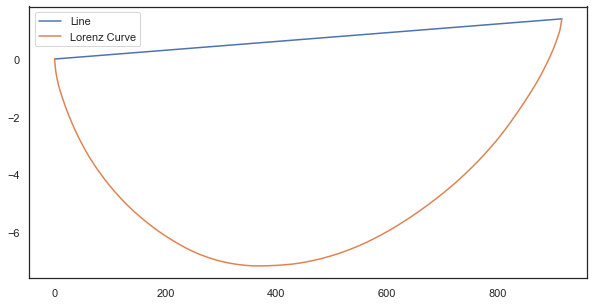

In [371]:
plt.figure(figsize = (10, 5))
plt.plot(Line["Returns"].values)
plt.plot(LorenzCurve["Returns"].values)
plt.legend(["Line", "Lorenz Curve"])

In [372]:
GINI_COEF(returns)

0.7238849137370992

### No. 2

In [316]:
def ytm(fv, n, c, r, pv):
    return ((c+((fv-pv)/n))/((fv+pv)/2))

In [317]:
print(str(round(ytm(1000, 20, 17.5, 0.035, 983.125)*100,5)) + "%")

1.84998%


In [318]:
print(str(round(ytm(1000, 10, 35, 0.035, 983.125)*100,5)) + "%")

3.69997%


### No. 3

In [18]:
df = pd.read_excel('ex_rates.xlsx', index_col = 0, parse_dates = True)
df['United States'] = 1

In [19]:
irs = pd.read_csv('Hw3_Interest_Rates.csv', index_col = 0, parse_dates = True)

In [20]:
irs = irs.drop(columns=['Canada','Australia','Switzerland','United Kingdom','Japan','Norway','New Zealand', 'Sweden'])

In [21]:
irs = irs.fillna(method='ffill')

In [22]:
irs.isnull().values.sum()

0

In [24]:
# calculate the currencies with the highest and lowest yields each period
maxI = irs.idxmax(axis = 1)
minI = irs.idxmin(axis = 1)

In [25]:
#ex = pd.DataFrame([maxI, minI]).T
#ex.columns = ["High Yield", "Low Yield"]
#ex

In [92]:
profits = np.array([])
for j in range(len(df)-1):
    
    # identify the country with the highest (long)
    # and lowest (short) yield
    long = maxI[j]
    short = minI[j]
    
    # get the exchange rate at t0 and t+1
    # for the short
    sts0 = df[short][j]
    sts1 = df[short][j+1]
    
    # get the monthly interest rate
    # for the short
    si = irs[short][j]
    
    # calculate the amount owed
    owed = 10000*sts0*si/sts1
    
    # get the exchange rate at t0 and t+1
    # for the long
    stl0 = df[long][j]
    stl1 = df[long][j+1]
    
    # get the monthly interest rate for the long
    li = irs[long][j]
    
    # calculate the ending balance
    balance = 10000*stl0*li/stl1
    
    # calculate the profit
    profit = balance - owed
    
    # store the profits
    profits = np.append(profits, profit)
    
    #print(profit)
    
    
profits = pd.DataFrame(profits, index = irs.index[:-1], columns = ["Profit"])

,Profit
date,
2000-02-01,20.229163
2000-03-01,20.583626
2000-04-01,17.976983
2000-05-01,17.655060
2000-06-01,18.866714
...,...
2022-08-01,19.513585
2022-09-01,17.836146
2022-10-01,19.159555


In [27]:
#yearly_profits

In [91]:
yearly_profits = profits.Profit.resample('Y').sum()
cumulative_yearly = profits.Profit.resample('Y').sum().cumsum()
cumulative_yearly

date
2000-12-31     176.714534
2001-12-31     258.344467
2002-12-31     420.232320
2003-12-31     539.377092
2004-12-31     600.497622
2005-12-31     730.857850
2006-12-31     929.119653
2007-12-31    1019.137276
2008-12-31    1175.448557
2009-12-31    1243.382806
2010-12-31    1293.168575
2011-12-31    1400.403543
2012-12-31    1430.984642
2013-12-31    1436.881276
2014-12-31    1448.367405
2015-12-31    1472.958874
2016-12-31    1563.519147
2017-12-31    1711.432683
2018-12-31    1960.437196
2019-12-31    2214.541618
2020-12-31    2317.250851
2021-12-31    2383.298335
2022-12-31    2567.527491
Freq: A-DEC, Name: Profit, dtype: float64

In [29]:
rorY = profits.Profit.resample('Y').sum()/10000*100

In [30]:
df_cumulative_yearly = pd.DataFrame(data=cumulative_yearly)

In [31]:
Total_Profits = df_cumulative_yearly.Profit.values[-1:]

In [32]:
TROR = (Total_Profits/10000)
TROR = float(TROR)
print("The total rate of return is: " + str(round(TROR,8)*100) + "%")

The total rate of return is: 25.675275%


In [33]:
ATROR = (TROR +1)**(1/23)-1
ATROR*100

print("The annual rate of return is: " + str(round(ATROR,8)*100) + "%")

The annual rate of return is: 0.998567%


In [34]:
# Alpha & Beta:

sp500 = yf.download("^GSPC", start="2000-01-01", end="2023-01-01", interval="1mo")[["Adj Close"]]
sp500.index = sp500.index.strftime('%Y-%m-%d')

[*********************100%***********************]  1 of 1 completed


In [35]:
drange = pd.date_range(start ='2000-01-31', end = '2022-12-31', freq = "M")
sp500.index = drange

In [36]:
sp500["market_returns"] = np.log(sp500["Adj Close"]).diff()

In [37]:
sp500 = sp500.iloc[1:, :]

In [38]:
rf_rate = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()
rf_rate = (rf_rate/100+1)**(1/12)-1

In [39]:
rorM = profits.Profit.resample('M').sum()/10000
df_rorM = pd.DataFrame(data=rorM)

In [40]:
drange = pd.date_range(start ='2000-02-01', end = '2022-12-31', freq = "M")
df_rorM.reindex = drange

df_rorM["rf"] = rf_rate
df_rorM["rf"] = df_rorM["rf"].ffill()

In [41]:
df_rorM["SP500"] = sp500['market_returns']

In [42]:
df_rorM['Profit_excess'] = df_rorM['Profit']-df_rorM['rf']

df_rorM['market_excess'] = df_rorM['SP500']-df_rorM['rf']

In [43]:
smf.ols('Profit_excess~market_excess', data = df_rorM).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Profit_excess   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.546
Date:                Wed, 08 Mar 2023   Prob (F-statistic):             0.0608
Time:                        11:19:15   Log-Likelihood:                 1460.7
No. Observations:                 275   AIC:                            -2917.
Df Residuals:                     273   BIC:                            -2910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0005   7.23e-05     -7.112      0.000      -0.001      -0.000
market_excess     0.0030      0.002      1.883      0.061      -0.000       0.006
==============================================================================
Omnibus:                       45.020   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.808
Skew:                          -1.176   Prob(JB):                     1.39e-14
Kurtosis:                       3.190   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Sharpe

(df_rorM['Profit'].mean()-df_rorM['rf'].mean())/df_rorM['Profit'].std()

-0.7902791279077942

In [45]:
# Gini

returns = df_rorM[['Profit']]
returns.columns = ['Returns']

In [46]:
 # get the number of periods -> will allow us to calculate the areas
periods = len(returns)
    
    # sort values and sum to calculate the lorenz curve
LorenzCurve = np.cumsum(returns.sort_values( by = "Returns"))
    # start from 0
LorenzCurve = pd.DataFrame({ 'Returns': [0]}).append(LorenzCurve)
Line = LorenzCurve.copy()
    # Form the line that encompasses A and B
Line["Returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["Returns"])
    
    # calculate the area of A+B
UpArea = 0
for i in range(1,len(returns)):
    UpArea = UpArea + ((Line.iloc[i,:] - LorenzCurve.iloc[i,:] + Line.iloc[i-1,:] - LorenzCurve.iloc[i-1,:]) / 2)
    # calculate the area of A+B+C
    if min(LorenzCurve["Returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["Returns"])) * periods) + ((max(LorenzCurve["Returns"]) * periods)/2)
    else:
        AllArea = ((max(LorenzCurve["Returns"]) * periods)/2)
gini = UpArea / AllArea

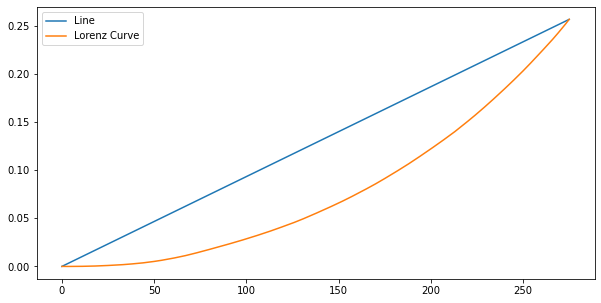

In [47]:
plt.figure(figsize = (10, 5))
plt.plot(Line["Returns"].values)
plt.plot(LorenzCurve["Returns"].values)
plt.legend(["Line", "Lorenz Curve"])

In [50]:
GINI_COEF(returns)

0.3911003704291757

### No. 4

#### a)

The paragraph attemps to rationalise the developments in the stock market in the recent past. For all market participants, it is clear that the Fed needs remain cautious in its outlook as the current era of economic instability with higher than usual inflation rates is not over yet. Nonetheless, remaining cautious in its communication without obvious further escalation in economic fundamentals may lead to increased scepticism among investors about the economic picture that the Fed portrays. Hence, it is not unlikely that investors make more risky investments than expected, in spite of the cautious macroeconomic guidance from the Fed. The article shows that it appears to be the case that many market participants ignore the warnings about potential further rate rise from the Fed and about lower earnings results in the US economy and instead bet on a strong economic rebound in the near future. 

#### b)

The effect of the questionable optimism among investors on stock prices is that they show a more positive development in the recent past than one would expect in the current economic conditions. 

### No. 5

The article argues that an alternative explanation could be that stocks have become more responsive to alternative factors and less responsive to bond yields. These alternative factors include the fact that the expectation for economic growth, leading to higher profits in the near term, have improved and that inflation has gone down recently. Both factors make the threat of higher bond yields appear weaker and could be reasons for the rise in stock market prices in early 2023.

In [130]:
#df_rorM['rfr'] = df_rorM
#df_rorM = df_rorM.ffill()
#df_rorM['returns_in_pct'] = df_rorM['returns']*100
#df_copy['rfr_52'] = df_copy['rfr']/52

In [301]:
# compounded
P = 100
A = (((cp["Profit"]/100)+1)*P)[-1]
t = (len(cp))
CCROR = np.log(A/P)/t
print(CCROR*100)

13.66133170676955


In [302]:
# Annualised: 

((A/P)**(1/t)-1)*100

14.63847753770171

In [343]:
# Gini

#cp = profits.resample('Y').sum().cumsum().append(pd.DataFrame(0, index = [pd.to_datetime("12/31/1999")], columns = ['Profit'])).sort_index()

#returns = cp[["Profit"]].iloc[1:]
#returns.columns = ['Returns']